# Data Driven Monte Carlo Experiments

In [1]:
import sys
sys.path.append("../src")
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from project import preprocessing, rf_models, mc_experiments

In [4]:
df_ic = pd.read_csv("../data/initial_custody_2017_gsprs.csv", low_memory=False)

## [Initial Custody] Building Random Forest With Original Data

In [5]:
df = preprocessing.preprocess_input_vars(df_ic)
data = df[
    [
        "gender_female",
        "age_gt_45",
        "age_lt_25",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O",
        "off_1_prs_max",
        "off_1_gs_max",
        "ic_custdy_level",
        "prior_commits",
        "ic_institut_adj",
        "escape_hist_1",
        "escape_hist_2",
        "escape_hist_3",
        "escape_hist_4",
        "escape_hist_5",
        "mrt_stat_DIV",
        "mrt_stat_SEP",
        "mrt_stat_MAR",
        "mrt_stat_WID",
        "employed",
        "control_number"
    ]
]
data = data[data["ic_custdy_level"] > 1]
data = data.dropna()

In [6]:
len(data)

13815

In [7]:
X = data.drop(["control_number", "ic_custdy_level"], axis=1)
Y = data["ic_custdy_level"]

In [8]:
# Create random forest with original data
ic_rf_model = rf_models.BasicRFModel(X, Y)
ic_rf_model.fit()

In [9]:
ic_col_enumerated = {
    col: dict(data.groupby(["ic_custdy_level"])[col].apply(list))
    for col in data.drop("ic_custdy_level", axis=1) 
}

In [10]:
ic_col_enumerated_2lvl = {
    col: dict(data.groupby([
        "ic_custdy_level",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O"])[col].apply(list))
    for col in data.drop([
        "ic_custdy_level",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O"], axis=1) 
}

## [Initial Custody] Empirical Super Sampling Experiment

In [11]:
ic_ess_fn = mc_experiments.gen_empirical_super_sampling_fn(
    col_enumerated = ic_col_enumerated,
    multi_lvl = False,
    consistency_cols= [
        ( "age_gt_45", "age_lt_25" ),
        ( "race_B", "race_A", "race_H", "race_I", "race_O" ),
        ( "escape_hist_1", "escape_hist_2", "escape_hist_3", "escape_hist_4", "escape_hist_5" ),
        ( "mrt_stat_DIV", "mrt_stat_SEP", "mrt_stat_MAR", "mrt_stat_WID" )
    ],
    const_cols = [
        "ic_custdy_level",
        "control_number"
    ]
)

In [16]:
ic_emp_super_sampling_mc = mc_experiments.MCExp(data, "ic_custdy_level", ic_rf_model)

In [ ]:
ic_emp_super_sampling_mc.run_sim(
    N=100,
    sampling_fn=ic_ess_fn,
    ignore_vars=[ "control_number" ]
)

In [ ]:
ic_emp_super_sampling_mc.plot_result_hist(True, save_to="../paper/images/ic_emp_SuperSampling.png")

In [11]:
ic_ess_fn_2lvl = mc_experiments.gen_empirical_super_sampling_fn(
    col_enumerated = ic_col_enumerated_2lvl,
    multi_lvl = True,
    consistency_cols=[
        ( "age_gt_45", "age_lt_25" ),
        ( "race_B", "race_A", "race_H", "race_I", "race_O" ),
        ( "escape_hist_1", "escape_hist_2", "escape_hist_3", "escape_hist_4", "escape_hist_5" ),
        ( "mrt_stat_DIV", "mrt_stat_SEP", "mrt_stat_MAR", "mrt_stat_WID" )
    ],
    const_cols =[
        "ic_custdy_level",
        "control_number",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O"
    ],
    group_cols=[
        "ic_custdy_level",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O"
    ]
)

In [12]:
ic_emp_super_sampling_mc_2lvl = mc_experiments.MCExp(data, "ic_custdy_level", ic_rf_model)

In [13]:
ic_emp_super_sampling_mc_2lvl.run_sim(
    N=100,
    sampling_fn=ic_ess_fn_2lvl,
    ignore_vars=[ "control_number" ]
)

In [ ]:
ic_emp_super_sampling_mc_2lvl.plot_result_hist(True, save_to="../paper/images/ic_emp_SuperSampling_grpby_CustRace.png")

In [14]:
for _, result in ic_emp_super_sampling_mc_2lvl.results.items():
    result["race_B"] = result.control_number.apply(
        lambda ctrl: data[data.control_number == ctrl]["race_B"].values[0]
    )
    result["race_W"] = result.control_number.apply(
        lambda ctrl: 1 if (
            data[data.control_number == ctrl]["race_B"].values[0] == 0 and
            data[data.control_number == ctrl]["race_A"].values[0] == 0 and 
            data[data.control_number == ctrl]["race_I"].values[0] == 0 and 
            data[data.control_number == ctrl]["race_H"].values[0] == 0 and 
            data[data.control_number == ctrl]["race_O"].values[0] == 0 
            ) else 0
    )

In [19]:
ic_emp_super_sampling_mc_2lvl.results[2].groupby("race_W")["change"].value_counts()

race_W  change
0       0.0       20745
        1.0       13602
        2.0        4853
1       1.0       40417
        0.0       27648
        2.0       25135
Name: change, dtype: int64

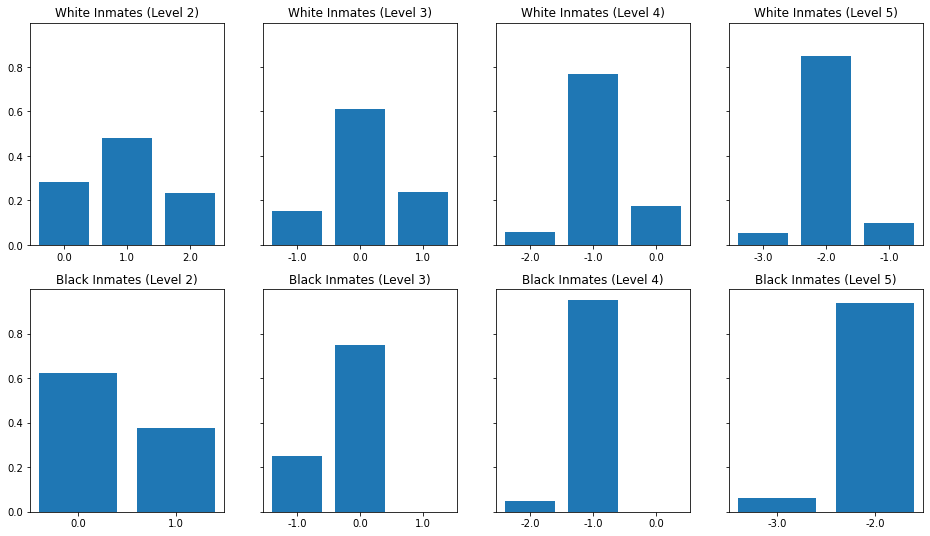

In [15]:
fig, ax = plt.subplots(2, len(ic_emp_super_sampling_mc_2lvl.results), figsize=(16, 9), sharey=True)
for i, lvl in enumerate(sorted(ic_emp_super_sampling_mc_2lvl.results.keys())):
    change_value_counts_W = ic_emp_super_sampling_mc_2lvl.results[lvl]\
        .groupby("race_W")["change"]\
        .value_counts(normalize=True)[1]
    ax[0][i].bar(list(change_value_counts_W.index), list(change_value_counts_W.values))
    ax[0][i].set_xticks(list(change_value_counts_W.index))
    ax[0][i].set_xticklabels(list(change_value_counts_W.index))
    ax[0][i].set_title(f"White Inmates (Level {int(lvl)})")

    change_value_counts_B = ic_emp_super_sampling_mc_2lvl.results[lvl]\
        .groupby("race_B")["change"]\
        .value_counts(normalize=True)[1]
    ax[1][i].bar(list(change_value_counts_B.index), list(change_value_counts_B.values))
    ax[1][i].set_xticks(list(change_value_counts_B.index))
    ax[1][i].set_xticklabels(list(change_value_counts_B.index))
    ax[1][i].set_title(f"Black Inmates (Level {int(lvl)})")
    
fig.savefig("../paper/images/ic_emp_SuperSampling_grpby_CustRace_Separate.png")

## [Initial Custody] Empirical One Col Sampling Experiment

In [19]:
ic_eocs_fn = mc_experiments.gen_empirical_one_col_sampling_fn(
    col_enumerated=ic_col_enumerated,
    const_cols=[
        "ic_custdy_level",
        "control_number"
    ]
)

In [20]:
ic_emp_one_col_sampling_mc = mc_experiments.MCExp(data, "ic_custdy_level", ic_rf_model)

In [21]:
ic_emp_one_col_sampling_mc.run_sim(
    N=100,
    sampling_fn=ic_eocs_fn,
    ignore_vars=[ "control_number" ]
)

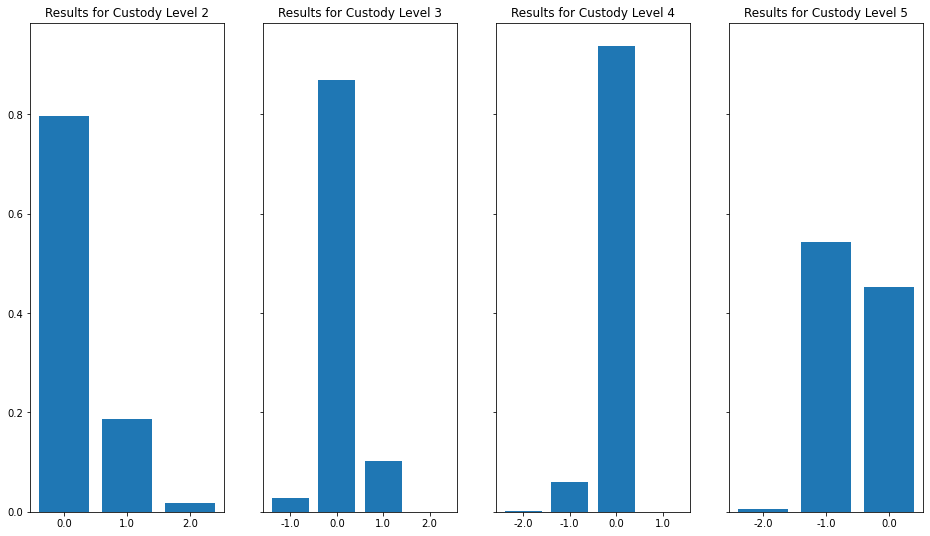

In [22]:
ic_emp_one_col_sampling_mc.plot_result_hist(True, save_to="../paper/images/ic_emp_OneColSampling.png")

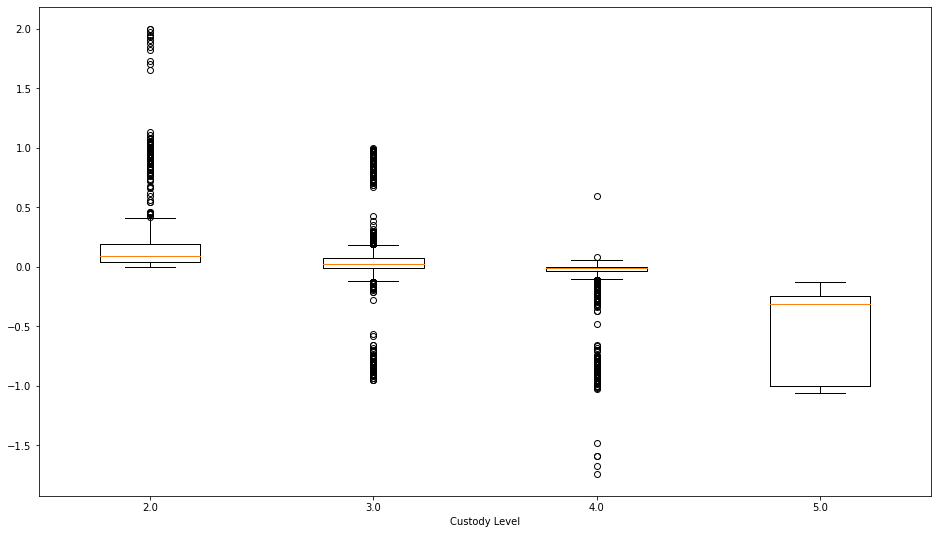

In [23]:
ic_emp_one_col_sampling_mc.plot_mean_box(save_to="../paper/images/ic_emp_OneColSampling_boxplot.png")

In [16]:
ic_eocs_fn_2lvl = mc_experiments.gen_empirical_one_col_sampling_fn(
    col_enumerated = ic_col_enumerated_2lvl,
    multi_lvl= True,
    const_cols=[
        "ic_custdy_level",
        "control_number",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O"
    ],
    group_cols=[
        "ic_custdy_level",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O"
    ]
)

In [18]:
ic_emp_one_col_sampling_mc_2lvl = mc_experiments.MCExp(data, "ic_custdy_level", ic_rf_model)

In [19]:
ic_emp_one_col_sampling_mc_2lvl.run_sim(
    N=100,
    sampling_fn=ic_eocs_fn_2lvl,
    ignore_vars=[ "control_number" ]
)

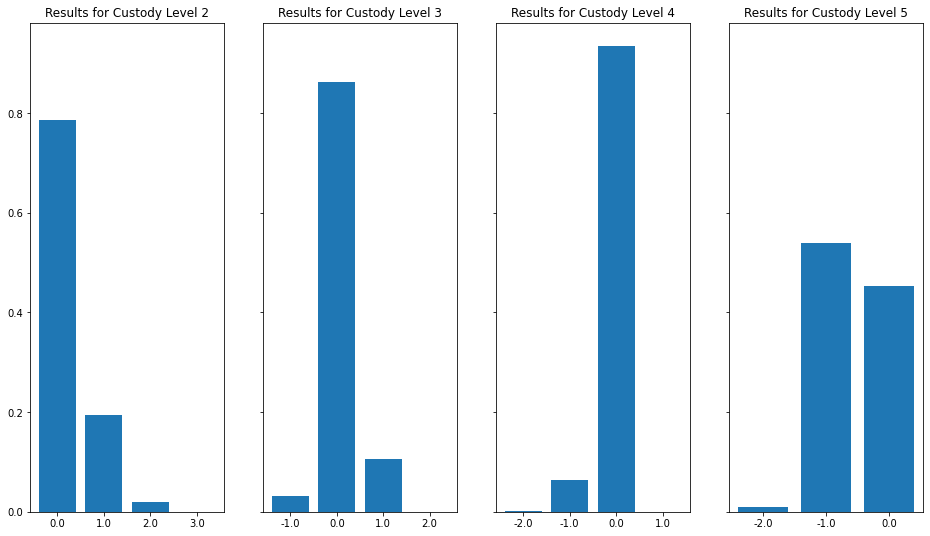

In [60]:
ic_emp_one_col_sampling_mc_2lvl.plot_result_hist(normalize=True, save_to="../paper/images/ic_emp_OneColSampling_grpby_CustRace.png")

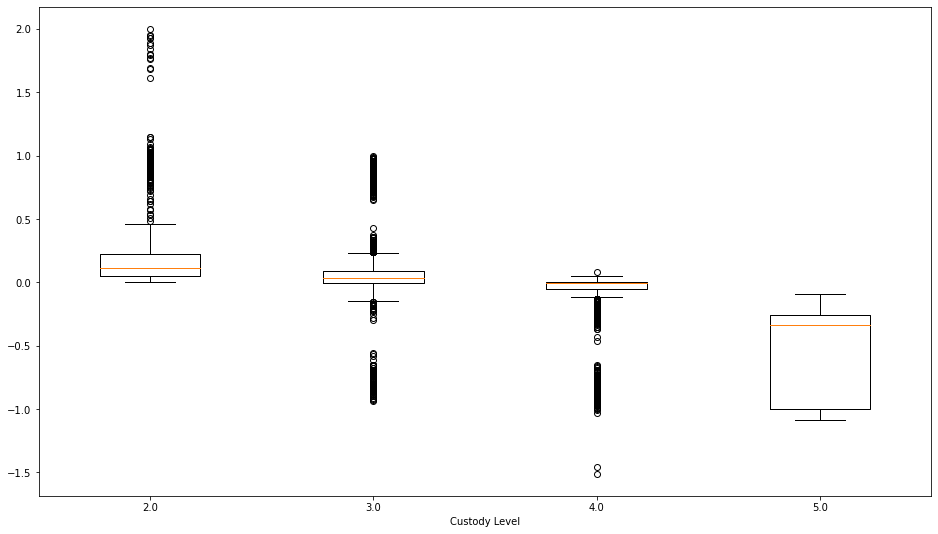

In [61]:
ic_emp_one_col_sampling_mc_2lvl.plot_mean_box(save_to="../paper/images/ic_emp_OneColSampling_grpby_CustRace_boxplot.png")

In [20]:
for _, result in ic_emp_one_col_sampling_mc_2lvl.results.items():
    result["race_B"] = result.control_number.apply(
        lambda ctrl: data[data.control_number == ctrl]["race_B"].values[0]
    )
    result["race_W"] = result.control_number.apply(
        lambda ctrl: 1 if (
            data[data.control_number == ctrl]["race_B"].values[0] == 0 and
            data[data.control_number == ctrl]["race_A"].values[0] == 0 and 
            data[data.control_number == ctrl]["race_I"].values[0] == 0 and 
            data[data.control_number == ctrl]["race_H"].values[0] == 0 and 
            data[data.control_number == ctrl]["race_O"].values[0] == 0 
            ) else 0
    )

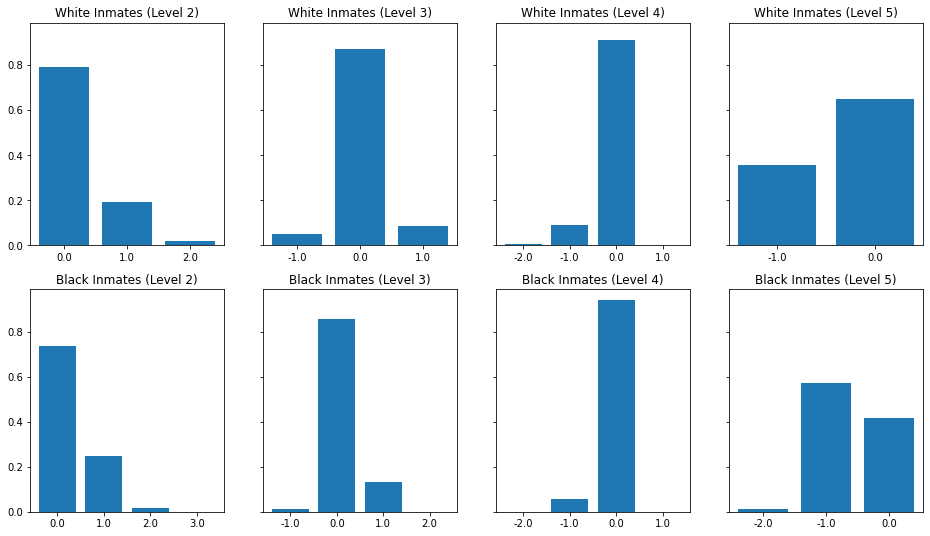

In [21]:
fig, ax = plt.subplots(2, len(ic_emp_one_col_sampling_mc_2lvl.results), figsize=(16, 9), sharey=True)
for i, lvl in enumerate(sorted(ic_emp_one_col_sampling_mc_2lvl.results.keys())):
    change_value_counts_W = ic_emp_one_col_sampling_mc_2lvl.results[lvl]\
        .groupby("race_W")["change"]\
        .value_counts(normalize=True)[1]
    ax[0][i].bar(list(change_value_counts_W.index), list(change_value_counts_W.values))
    ax[0][i].set_xticks(list(change_value_counts_W.index))
    ax[0][i].set_xticklabels(list(change_value_counts_W.index))
    ax[0][i].set_title(f"White Inmates (Level {int(lvl)})")

    change_value_counts_B = ic_emp_one_col_sampling_mc_2lvl.results[lvl]\
        .groupby("race_B")["change"]\
        .value_counts(normalize=True)[1]
    ax[1][i].bar(list(change_value_counts_B.index), list(change_value_counts_B.values))
    ax[1][i].set_xticks(list(change_value_counts_B.index))
    ax[1][i].set_xticklabels(list(change_value_counts_B.index))
    ax[1][i].set_title(f"Black Inmates (Level {int(lvl)})")
    
fig.savefig("../paper/images/ic_emp_OneColSampling_grpby_CustRace_Separate.png")

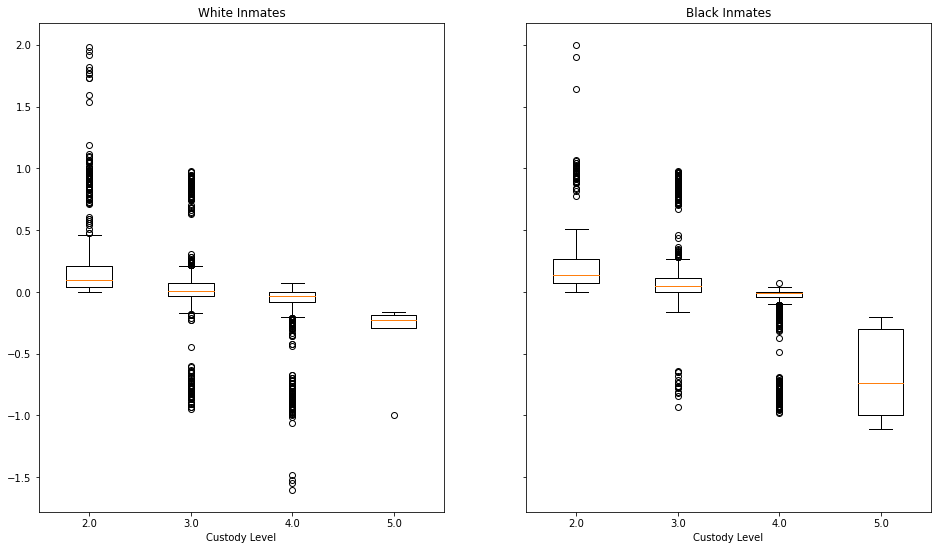

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 9), sharey=True)
changes_B = {
    lvl: (data[data["race_B"] == 1].groupby("control_number")["prediction"].mean() - lvl)
    for lvl, data in ic_emp_one_col_sampling_mc_2lvl.results.items()
}

changes_W = {
    lvl: (data[data["race_W"] == 1].groupby("control_number")["prediction"].mean() - lvl)
    for lvl, data in ic_emp_one_col_sampling_mc_2lvl.results.items()
}


ax[0].boxplot([ changes_W[k] for k in sorted(changes_W.keys()) ])
ax[0].set_xlabel("Custody Level")
ax[0].set_xticklabels(sorted(changes_W.keys()))
ax[0].set_title("White Inmates")


ax[1].boxplot([ changes_B[k] for k in sorted(changes_B.keys()) ])
ax[1].set_xlabel("Custody Level")
ax[1].set_xticklabels(sorted(changes_B.keys()))
ax[1].set_title("Black Inmates");

fig.savefig("../paper/images/ic_emp_OneColSampling_grpby_CustRace_boxplot_Separate.png")